# Tổng quan

Vì dữ liệu 191GB nên em up sample dataset với 30 ảnh lên để tổng quan về dữ liệu trước.
Download tại [link](https://drive.google.com/drive/folders/1xEcsZFq596lOIqejHgZTmNRs_SMdGnd4?usp=sharing)


Dữ liệu được lưu dưới định dạng DICOM

Tập train với 15,000 ảnh

Tập public test với 3,000 ảnh

Ảnh được gắn với 14 nhãn:

0 - Aortic enlargement

1 - Atelectasis

2 - Calcification

3 - Cardiomegaly

4 - Consolidation

5 - ILD

6 - Infiltration

7 - Lung Opacity

8 - Nodule/Mass

9 - Other lesion

10 - Pleural effusion

11 - Pleural thickening

12 - Pneumothorax

13 - Pulmonary fibrosis

14 - "No finding" observation was intended to capture the absence of all findings above

**Ở đây nhãn được gắn bởi nhiều chuyên gia X quang, nghĩa là một ảnh sẽ có nhiều ground-truth!**

## Dữ liệu mẫu

Mô tả dữ liệu:

train.csv: metadata của tập train, với mỗi hàng là một mẫu ảnh, bao gồm tên nhãn và bounding box (một ảnh có thể có nhiều hàng)

![figures](figures/overview_data.PNG)

Các cột trong train.csv

- image_id: tên dữ liệu
- class_name: tên của nhãn có trong ảnh (nêu không có thì hiện "No finding")
- class_id: ID của nhãn có trong ảnh (từ 0 đến 14)
- rad_id: ID của chuyên gia X quang, người gắn nhãn
- x_min: minimum X coordinate of the object's bounding box
- y_min: minimum Y coordinate of the object's bounding box
- x_max: maximum X coordinate of the object's bounding box
- y_max: maximum Y coordinate of the object's bounding box

sample_submission.csv: sample submission file in the correct format

**Đầu ra của bài toán là một model có thể khoanh vùng và phân loại 14 loại bất thường trong ảnh**

Tìm hiểu sâu về 14 loại bất thường có thể tham khảo repo sau:

[https://www.kaggle.com/sakuraandblackcat/chest-x-ray-knowledges-for-the-14-abnormalities](https://www.kaggle.com/sakuraandblackcat/chest-x-ray-knowledges-for-the-14-abnormalities)


## Visualize dữ liệu

#### Import libraries

In [16]:
import os
from tqdm import tqdm
import sys
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from random import randint
import cv2

import pydicom
# remember to install : pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg
# follow: https://pydicom.github.io/pydicom/dev/tutorials/installation.html
from pydicom.pixel_data_handlers.util import apply_voi_lut

from skimage import exposure
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

#### Setup global variables

In [2]:
DATA_DIR = "E:/Kaggle/VinBigData/"

# Define the paths to the training and testing dicom folders respectively
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

In [3]:
# Capture all the relevant full train/test paths
TRAIN_DICOM_PATHS = [os.path.join(TRAIN_DIR, f_name) for f_name in os.listdir(TRAIN_DIR)]
TEST_DICOM_PATHS = [os.path.join(TEST_DIR, f_name) for f_name in os.listdir(TEST_DIR)]
print("The number of training files is {}".format(len(TRAIN_DICOM_PATHS)))
print("The number of testing files is {}".format(len(TEST_DICOM_PATHS)))

The number of training files is 15000
The number of testing files is 3000


In [4]:
# Define paths to the relevant csv files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")

In [5]:
# Create the relevant dataframe objects
train_df = pd.read_csv(TRAIN_CSV)
# Create 'rad_label" -> multi groundtruth
le = preprocessing.LabelEncoder()
train_df['rad_label'] = le.fit_transform(train_df['rad_id'])

ss_df = pd.read_csv(SS_CSV)

## Tìm hiểu về định dạng DICOM?

Tham khảo tại: https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data

In [6]:
test_dicom = pydicom.read_file(TRAIN_DICOM_PATHS[2])

In [7]:
test_dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 154
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 0005e8e3701dfb1dd93d53e2ff537b6e
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's Age                       AS: '028Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0008) Number of Frames                    IS: "1"
(0028, 0010) Rows                                US: 3072
(0028, 0011) Columns                   

### Chuyển từ định dạng DICOM về np.array cần lưu ý:

Source: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way

"you must consider, that raw dicom data is not actually linearly convertable to "human-friendly" png/jpg. In fact, most of DICOM's store pixel values in exponential scale, which is resolved by standard standard DICOM viewers.

So in order to get jpg/png as radiologists would initially see in their workspace, you need to apply some transformations. DICOM metadata stores information how to make such "human-friendly" transformations."

In [8]:
# dicom2array
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data

In [9]:
img = dicom2array(TRAIN_DICOM_PATHS[1])

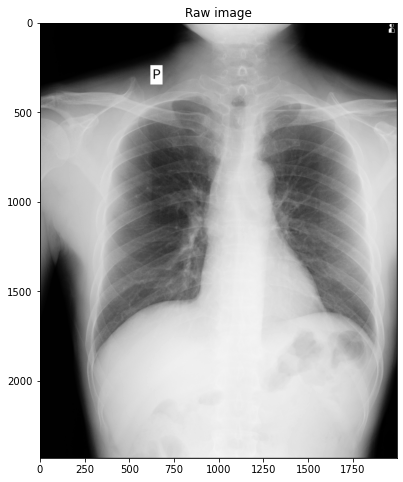

In [10]:
plt.figure(figsize = (8,8))
plt.imshow(img, 'gray')
plt.title('Raw image')
plt.show()

## Some normalization techniques

Source: https://www.kaggle.com/raddar/popular-x-ray-image-normalization-techniques

### Histogram normalization

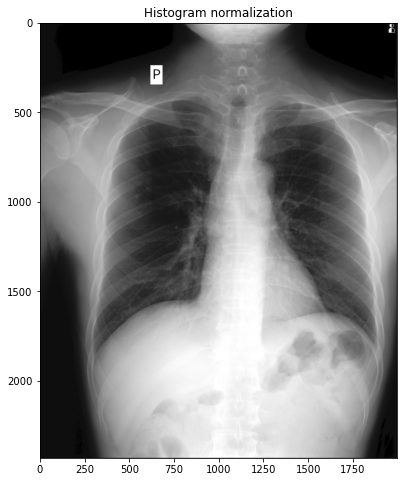

In [11]:
img_histogram_normalize = exposure.equalize_hist(img)

plt.figure(figsize = (8,8))
plt.imshow(img_histogram_normalize, 'gray')
plt.title('Histogram normalization')
plt.show()

### CLAHE normalization

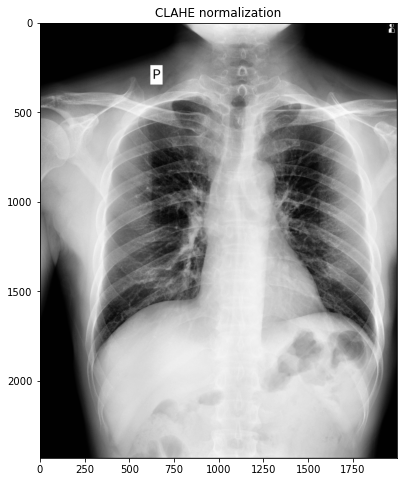

In [12]:
img_clahe_normalization = exposure.equalize_adapthist(img/np.max(img))

plt.figure(figsize = (8,8))
plt.imshow(img_clahe_normalization, 'gray')
plt.title('CLAHE normalization')
plt.show()

## Plot with bounding box

Bounding box coordinates

![figure](figures/bbox.PNG)

In [13]:
def get_bbox_area(row):
    return (row['x_max']-row['x_min'])*(row['y_max']-row['y_min'])

def get_bbox_df():
    bbox_df = train_df[train_df['class_name'] != 'No finding']
    bbox_df['bbox_area'] = bbox_df.apply(get_bbox_area, axis=1)
    return bbox_df

In [14]:
bbox_df = get_bbox_df()
bbox_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,rad_label,bbox_area
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,1,438672.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1,95772.0
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,16,24320.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,8,1618084.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,16,15576.0


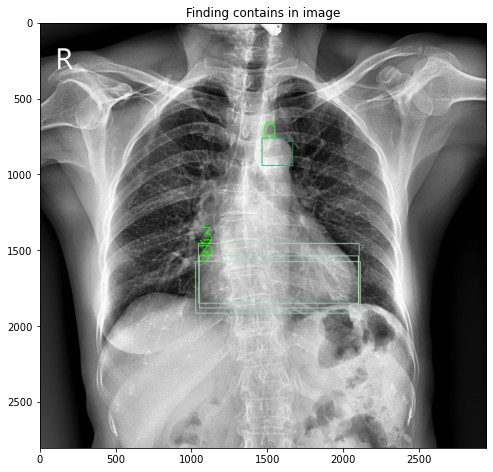

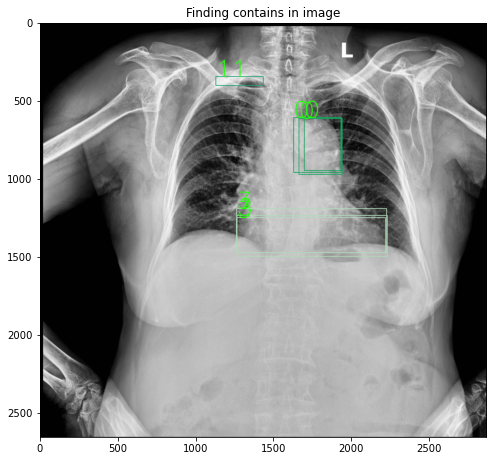

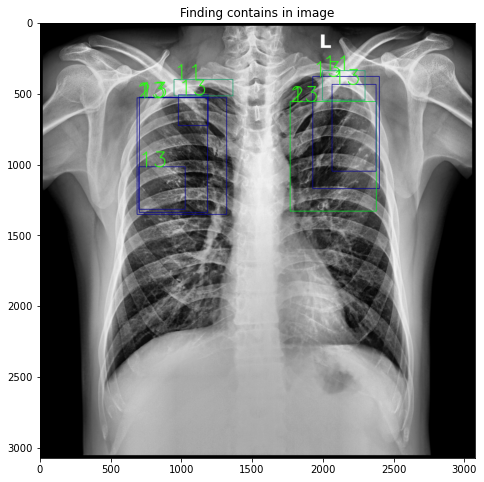

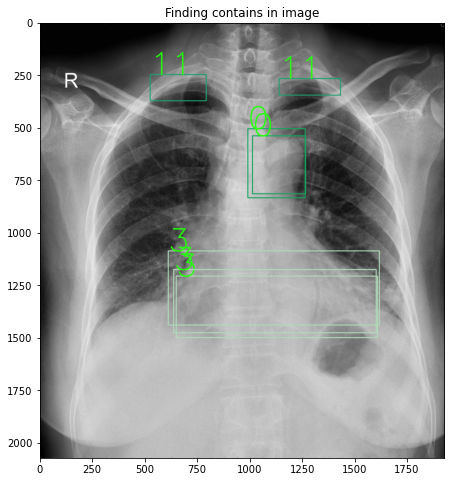

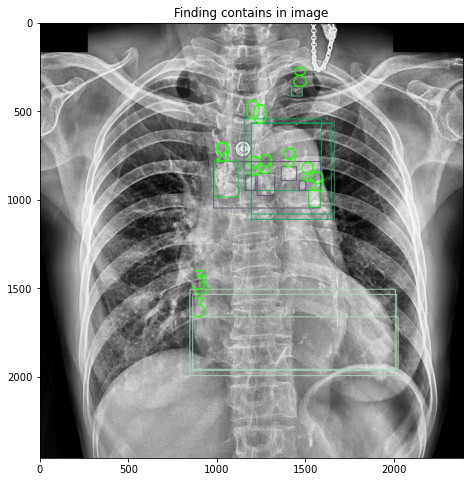

In [15]:
def plot_bbox(num_visualize = 5):
    img_ids = bbox_df['image_id'].values

    class_ids = bbox_df['class_id'].unique()
    label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}

    for i in range(num_visualize):
        img_id = random.choice(img_ids)
        img_path = os.path.join(TRAIN_DIR, img_id + ".dicom")
        img = dicom2array(img_path)

        # normalize
        img = exposure.equalize_adapthist(img/np.max(img))
        img = (img * 255).astype(np.uint8)

        # --- Convert from single-channel grayscale to 3-channel RGB
        img = np.stack([img] * 3, axis=2)

        # add bounding boxes
        box_coordinates = bbox_df.loc[bbox_df['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
        labels = bbox_df.loc[bbox_df['image_id'] == img_id, ['class_id']].values.squeeze()
        for label_id, box in zip(labels, box_coordinates):
            color = label2color[label_id]
            img_bbox = cv2.rectangle(
                img,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                color = color, thickness= 3
            )
            # add labels
            cv2.putText(img_bbox, str(label_id), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 5, (36,255,12), 5)

        plt.figure(figsize=(8,8))
        plt.imshow(img_bbox, cmap = 'gray')
        plt.title('Finding contains in image')
        plt.show()
plot_bbox(num_visualize = 5)

## Explore features distribution

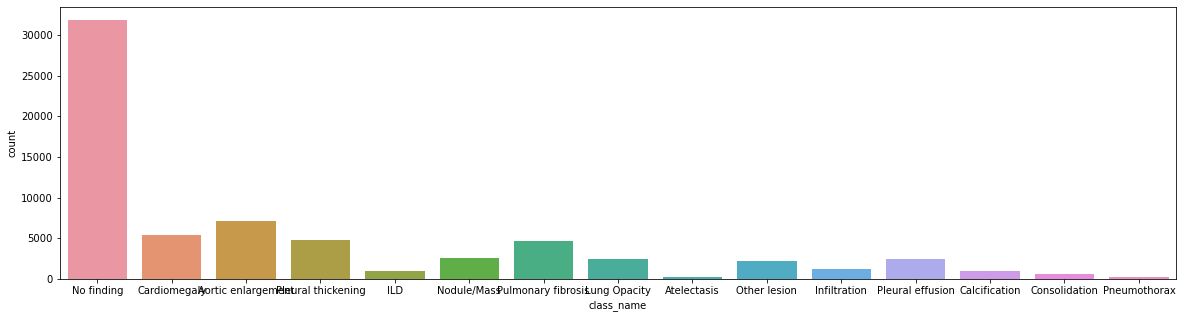

In [21]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'class_name', data = train_df)
plt.title('Class name distribution')
plt.show()


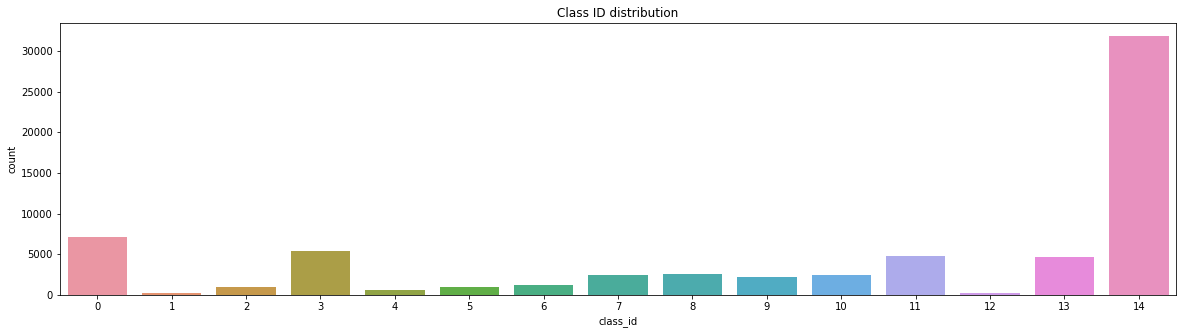

In [22]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'class_id', data = train_df)
plt.title('Class ID distribution')
plt.show()


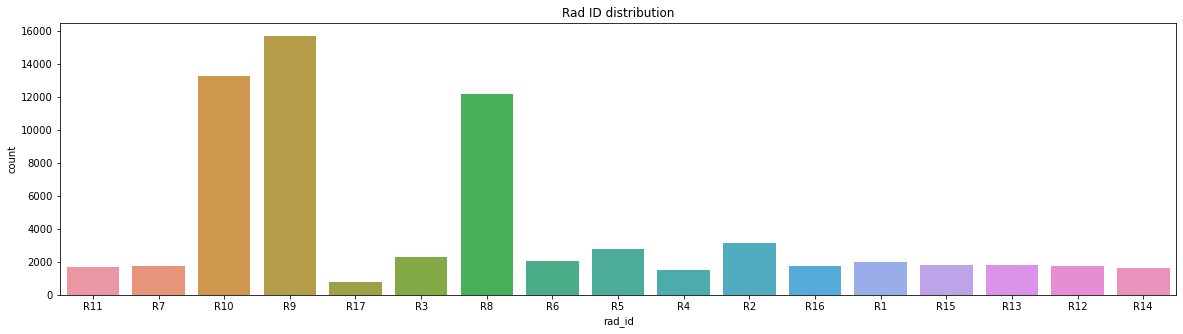

In [23]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'rad_id', data = train_df)
plt.title('Rad ID distribution')
plt.show()


****

### Tổng hợp code từ sources:
1. https://www.kaggle.com/dschettler8845/visual-in-depth-eda-vinbigdata-competition-data
2. https://www.kaggle.com/sakuraandblackcat/chest-x-ray-knowledges-for-the-14-abnormalities
3. https://www.kaggle.com/trungthanhnguyen0502/eda-vinbigdata-chest-x-ray-abnormalities